### Основные импорты

In [106]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pathlib

### Загрузка данных

In [98]:
data_path = pathlib.Path("../data/")

offers = pd.read_csv(data_path / "d_offer.csv")
lots = pd.read_csv(data_path / "d_lot.csv")
lots_prods = pd.read_csv(data_path / "d_lot_prod.csv")
persons = pd.read_csv(data_path / "d_person.csv")

df_train = pd.read_csv(data_path / "all_ids_train.csv")
df_test = pd.read_csv(data_path / "all_ids_test.csv")

Сджойним данные по лотам и предложениям поставщиков:

In [99]:
def get_merged_data(df):
    merged_df = pd.merge(df, offers, left_on=["OFFER_ID", "LOT_ID"], right_on=["OFFER_ID", "LOT_ID"], how="left") # джойним к логам офферы
    merged_df = pd.merge(merged_df, persons, left_on="OFFER_PERSON_ID", right_on="PERSON_ID", how="left").drop("PERSON_ID", axis=1)
    merged_df = pd.merge(merged_df, persons, left_on="BUYER_PERSON_ID", right_on="PERSON_ID", suffixes=("_OFFER", "_BUYER")).drop("PERSON_ID", axis=1) # джойним к поставщикам и заказчикам их города
    
    merged_df = pd.merge(merged_df, lots, on="LOT_ID", how="left") # джойним лоты
    # merged_df = pd.merge(merged_df, lots_prods, on="LOT_ID", how="left") # джойним продукты в лотах, там целый список с количествами
    return merged_df

In [100]:
merged_train = get_merged_data(df_train)
merged_test = get_merged_data(df_test)
merged_train.head()

,LOT_ID,OFFER_ID,OFFER_PERSON_ID,BUYER_PERSON_ID,IS_SELLER,CANCELLED_FLAG,INCONSISTENT_FLAG,UNCONSIDERED_FLAG,REJECT_FLAG,CUSTOMER_REFUSAL_FLAG,AU_FO_PRICE,AU_STEPS_COUNT,OFFERED_PRICE_RUBLES,FINAL_PARENT_OKATO_NAME_OFFER,FINAL_PARENT_OKATO_NAME_BUYER,LOT_NAME,TOTAL_START_PRICE_RUBLES,TOTAL_O_G_AMOUNT_RUBLES,TOTAL_C_G_AMOUNT_RUBLES
0,1,1,11,954,1,0,0,0,0,0,165251.62,1.0,165251.62,Тамбовская область,Владимирская область,"Поставка лекарственных средств (Меропенем, цеф...",382429.25,3824.29,38242.93
1,1,2,5843,954,0,0,0,0,0,0,330801.28,1.0,330801.28,Владимирская область,Владимирская область,"Поставка лекарственных средств (Меропенем, цеф...",382429.25,3824.29,38242.93
2,1,3,1093,954,0,0,0,0,0,0,167163.77,1.0,167163.77,Рязанская область,Владимирская область,"Поставка лекарственных средств (Меропенем, цеф...",382429.25,3824.29,38242.93
3,1,4,21368,954,0,0,0,0,0,0,183566.01,1.0,183566.01,Москва,Владимирская область,"Поставка лекарственных средств (Меропенем, цеф...",382429.25,3824.29,38242.93
4,1,5,21358,954,0,0,0,0,0,0,204599.62,1.0,204599.62,Москва,Владимирская область,"Поставка лекарственных средств (Меропенем, цеф...",382429.25,3824.29,38242.93


### Исследование данных

##### Влияние флагов

Посмотрим, какие флаги могут быть выставлены в случае, если исполнен контракт.

В целом количество данных по каждому флагу выглядит следующим образом:


In [72]:
flags = ["CANCELLED_FLAG", "INCONSISTENT_FLAG", "UNCONSIDERED_FLAG", "REJECT_FLAG", "CUSTOMER_REFUSAL_FLAG"]
for flag in flags:
    count = merged_train[(merged_train["IS_SELLER"] == 1) & (merged_train[flag] == 1)][flag].count()
    print(f"{flag}: {count}")

CANCELLED_FLAG: 3
INCONSISTENT_FLAG: 476
UNCONSIDERED_FLAG: 0
REJECT_FLAG: 4
CUSTOMER_REFUSAL_FLAG: 4


Удивительным образом есть контракты, исполненные несмотря на то, что заказчик отказался от выполнения

##### Корреляции с исполнением заявки

Кажется, что мин цена в закупке должна однозначно определять таргет с поправкой на флаге.
Проверим этот факт.
Также построим heatmap.

Найдем минимум финальной цены по каждому лоту.
Длина выборки - общее число лотов.

In [73]:
lots_best_prices = merged_train[["LOT_ID", "OFFERED_PRICE_RUBLES"]].groupby("LOT_ID").min()
# нужно выбрать по каждый цене
print(len(lots_best_prices))

93465


In [80]:
persons_best_prices = pd.merge(merged_train[["LOT_ID", "IS_SELLER", "OFFER_PERSON_ID", "BUYER_PERSON_ID", "OFFERED_PRICE_RUBLES"] + flags], lots_best_prices, on=["LOT_ID", "OFFERED_PRICE_RUBLES"], how="inner")
# выбрали в каждом лоте селлеров с мин ценой
len(persons_best_prices)

103598

Мы выбрали несколько селлеров с одинаковой предложенной ценной в кажждом лоте.
Понятно, что из них только один победитель. В аукционах это первый сделавший ставку.
Посмотрим, сколько к нам попало селлеров с минимальной ценой.

In [76]:
persons_best_prices["IS_SELLER"].value_counts()

IS_SELLER
1    87989
0    15609
Name: count, dtype: int64

Мы видим, что есть 15 тысяч лотов, на которых не выиграли селлеры, предложившие мин цену, они могут быть дубликатами при джойне: просто ребятами, предложившими ту же цену, что и победитель, но позже или ребятами с отказами (установлены флаги)
Мы также видим, что не все (только 87 989 из 93 465) лоты закончились выигрышами с мин ценой. 
Сделаем сначала поправку на флаги.

In [91]:
from functools import reduce

all_frags_filter = reduce(lambda x, y : x & y, map(lambda flag: merged_train[flag] == 0, flags))

lots_best_prices_no_flags = merged_train[all_frags_filter][["LOT_ID", "OFFERED_PRICE_RUBLES"]].groupby("LOT_ID").min()
len(lots_best_prices_no_flags)

93007

In [92]:
persons_best_prices_no_flags = pd.merge(merged_train[all_frags_filter][["LOT_ID", "IS_SELLER", "OFFER_PERSON_ID", "BUYER_PERSON_ID", "OFFERED_PRICE_RUBLES"]], lots_best_prices_no_flags, on=["LOT_ID", "OFFERED_PRICE_RUBLES"], how="inner")
len(persons_best_prices_no_flags)

102436

In [93]:
persons_best_prices_no_flags["IS_SELLER"].value_counts()

IS_SELLER
1    92751
0     9685
Name: count, dtype: int64

Среди селлеров без установленных флагов почти все, кто установил минимальную цену, выиграли.
На остальных 256 лотах есть селлеры, которые единственные установили мин. цену, не имели флагов, но проиграли.
Можно считать остальных селлеров погрешностью (возможно на проирыш повлияли иные обстоятельства) или выкинуть из данных для лучше интерпритации. 
Помним также, что у нас были странные случаи выигрыша, несмотря на установку флага.

В любом случае признак почти однозначно определяет таргет, а в момент совершения предсказания не будет доступен.

In [102]:
merged_train.columns

Index(['LOT_ID', 'OFFER_ID', 'OFFER_PERSON_ID', 'BUYER_PERSON_ID', 'IS_SELLER',
       'CANCELLED_FLAG', 'INCONSISTENT_FLAG', 'UNCONSIDERED_FLAG',
       'REJECT_FLAG', 'CUSTOMER_REFUSAL_FLAG', 'AU_FO_PRICE', 'AU_STEPS_COUNT',
       'OFFERED_PRICE_RUBLES', 'FINAL_PARENT_OKATO_NAME_OFFER',
       'FINAL_PARENT_OKATO_NAME_BUYER', 'LOT_NAME', 'TOTAL_START_PRICE_RUBLES',
       'TOTAL_O_G_AMOUNT_RUBLES', 'TOTAL_C_G_AMOUNT_RUBLES'],
      dtype='object')

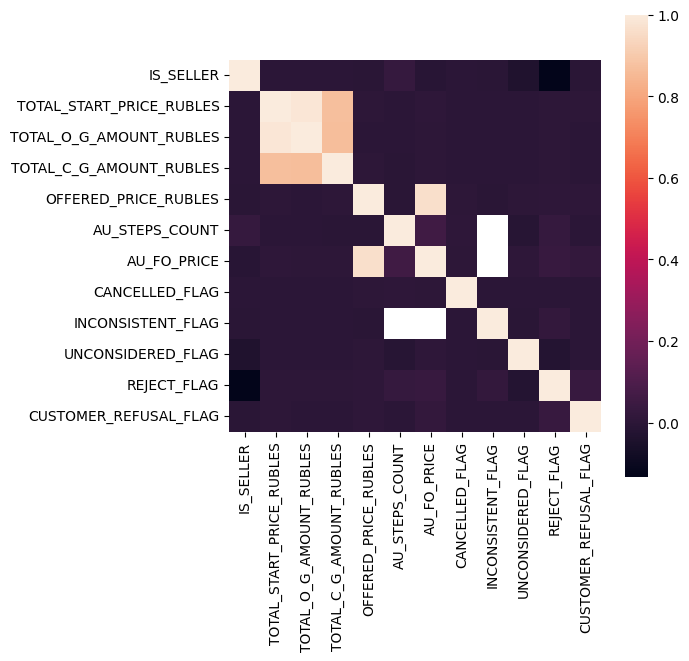

In [110]:
numeric_columns = ["IS_SELLER", "TOTAL_START_PRICE_RUBLES", "TOTAL_O_G_AMOUNT_RUBLES", "TOTAL_C_G_AMOUNT_RUBLES", "OFFERED_PRICE_RUBLES", "AU_STEPS_COUNT", "AU_FO_PRICE"] + flags
corrmap = merged_train[numeric_columns].corr()

fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(corrmap, square=True)
plt.show()

Удивительно, что таргет почти не коррелирует с флагами

##### Проверка пропусков

In [114]:
100 * (len(merged_train) - merged_train.count()) / len(merged_train)

LOT_ID                            0.000000
OFFER_ID                          0.000000
OFFER_PERSON_ID                   0.000000
BUYER_PERSON_ID                   0.000000
IS_SELLER                         0.000000
CANCELLED_FLAG                    0.000000
INCONSISTENT_FLAG                 0.000000
UNCONSIDERED_FLAG                 0.000000
REJECT_FLAG                       0.000000
CUSTOMER_REFUSAL_FLAG             0.000000
AU_FO_PRICE                      52.424855
AU_STEPS_COUNT                   52.424855
OFFERED_PRICE_RUBLES              4.505484
FINAL_PARENT_OKATO_NAME_OFFER     1.673539
FINAL_PARENT_OKATO_NAME_BUYER     2.671034
LOT_NAME                          0.000000
TOTAL_START_PRICE_RUBLES          0.782145
TOTAL_O_G_AMOUNT_RUBLES          32.300348
TOTAL_C_G_AMOUNT_RUBLES          47.802716
dtype: float64

Пропуски в основном в данных о ценах